In [1]:
import torch
import torchvision
import open_clip
import matplotlib.pyplot as plt
import copy

/scratch/ssd004/scratch/emzed/conda/envs/aft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai', device=device)
model_orig = copy.deepcopy(model)
my_model = copy.deepcopy(model)

model.visual.load_state_dict(torch.load("vit_b_16.pt", map_location=device))
state_dict = torch.load("clip_aft/outputs/checkpoints/final2.pt", map_location=device)
my_model.visual.load_state_dict({k.replace("model.", ""): v for k, v in state_dict.items()})
model.eval()
my_model.eval()
model_orig.eval()

CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-

In [18]:
imagenette = torchvision.datasets.ImageFolder(
    root='/datasets/imagenet/val/',
    transform=preprocess
)
dataloader = torch.utils.data.DataLoader(imagenette, batch_size=32, shuffle=True)

In [19]:
from clip_aft.utils.imagenet import IMAGENET_1K_CLASS_ID_TO_LABEL

template = 'This is a photo of a {}'
text_prompts = [template.format(c) for c in IMAGENET_1K_CLASS_ID_TO_LABEL.values()]
tokenizer = open_clip.get_tokenizer('ViT-B-16')

text_embeddings = []
for i in range(0, len(text_prompts), 32):
    batch = text_prompts[i:i+32]
    text_inputs = tokenizer(batch).to(device)
    with torch.no_grad():
        batch_embeddings = model.encode_text(text_inputs)
    text_embeddings.append(batch_embeddings)

text_embeddings = torch.cat(text_embeddings)

In [20]:
def get_importance_map_gradient(model, images):
    images = images.clone().detach().to(device).requires_grad_(True)

    outputs = model.encode_image(images)
    preds = outputs.argmax(dim=1)
    selected = outputs[torch.arange(outputs.size(0)), preds]

    grads = torch.autograd.grad(
        outputs=selected,
        inputs=images,
        grad_outputs=torch.ones_like(selected),
        create_graph=False,
        retain_graph=False,
        only_inputs=True
    )[0]

    importance = grads.abs().mean(dim=1)
    return importance.detach()


In [21]:
def mask_images(images, importance, mask_ratio):
    B, H, W = importance.shape
    k = int(H * W * mask_ratio)
    flat = importance.view(B, -1)
    topk_idx = torch.topk(flat, k, dim=1).indices

    masked_images = images.clone()
    for i in range(B):
        img = masked_images[i]
        imp = importance[i].flatten()
        mask = torch.ones_like(imp)
        mask[topk_idx[i]] = 0
        mask = mask.view(H, W).unsqueeze(0).repeat(3, 1, 1)
        masked_images[i] = img * mask
    return masked_images

In [26]:
def evaluate(model, cached_batches, importance_func, mask_ratio, mode='zero-shot'):
    total, correct = 0, 0
    n_iter = 0
    for images, labels in cached_batches:
        images, labels = images.to(device), labels.to(device)
        importance = importance_func(model, images)
        masked_images = mask_images(images, importance, mask_ratio)

        if mode == 'zero-shot':
            with torch.no_grad():
                image_features = model.encode_image(masked_images)
                logits = image_features @ text_embeddings.T
                preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return correct / total * 100

In [33]:
def run_roar_analysis(importance_func, title, max_iter=10):
    cached_batches = []
    for i, (images, labels) in enumerate(dataloader):
        if i >= max_iter:
            break
        cached_batches.append((images.to(device), labels.to(device)))

    mask_ratios = [0, 0.1, 0.3, 0.5]
    acc_zero_shot = {m_name: (m, []) for m, m_name in [(model, 'model'), (model_orig, 'model_orig'), (my_model, 'my_model')]}

    for m_name, (m, accs) in acc_zero_shot.items():
        print(m_name)
        for r in mask_ratios:
            print(r)
            accs.append(evaluate(m, cached_batches, importance_func, r, mode='zero-shot'))
            
    plt.figure(figsize=(7, 5))

    for model_name, (_, accs) in acc_zero_shot.items():
        plt.plot(
            [r * 100 for r in mask_ratios],
            accs,
            marker='o',
            label=model_name
        )

    plt.xlabel("Percentage of Pixels Masked (%)")
    plt.ylabel("Zero-shot Accuracy (%)")
    plt.title(f"ROAR Analysis on Zero-shot Classification w.r.t {title}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


model
0
0.1
0.3
0.5
model_orig
0
0.1
0.3
0.5
my_model
0
0.1
0.3
0.5


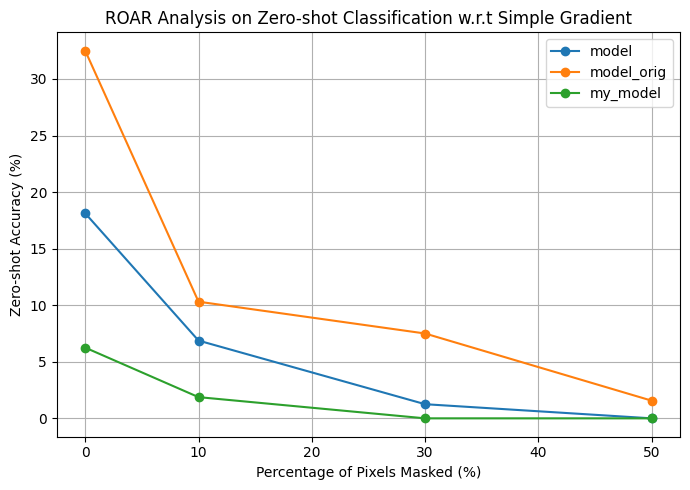

In [35]:
run_roar_analysis(get_importance_map_gradient, "Simple Gradient")

In [30]:
def get_importance_map_gradcam(model, images):
    images = images.to(device)
    images.requires_grad = True

    attn_weights = []

    def forward_hook(module, query, key, value, **kwargs):
        attn_output, attn = module.original_forward(query, key, value, need_weights=True, average_attn_weights=False)
        attn_weights.append(attn.detach())
        return attn_output

    mha = model.visual.transformer.resblocks[-1].attn
    mha.original_forward = mha.forward
    mha.forward = forward_hook.__get__(mha, type(mha))

    outputs = model.encode_image(images)
    preds = outputs.argmax(dim=1)
    loss = outputs[torch.arange(outputs.size(0)), preds].sum()
    loss.backward()

    mha.forward = mha.original_forward

    A = attn_weights[0]
    cls_attn = A[:, :, 0, 1:]
    importance = cls_attn.mean(dim=1)

    num_patches = importance.shape[-1]
    side = int(num_patches ** 0.5)
    importance = importance.view(-1, side, side)

    importance = torch.nn.functional.interpolate(
        importance.unsqueeze(1), size=images.shape[-2:], mode='bilinear', align_corners=False
    ).squeeze(1)

    return importance


model
0
0.1
0.3
0.5
model_orig
0
0.1
0.3
0.5
my_model
0
0.1
0.3
0.5


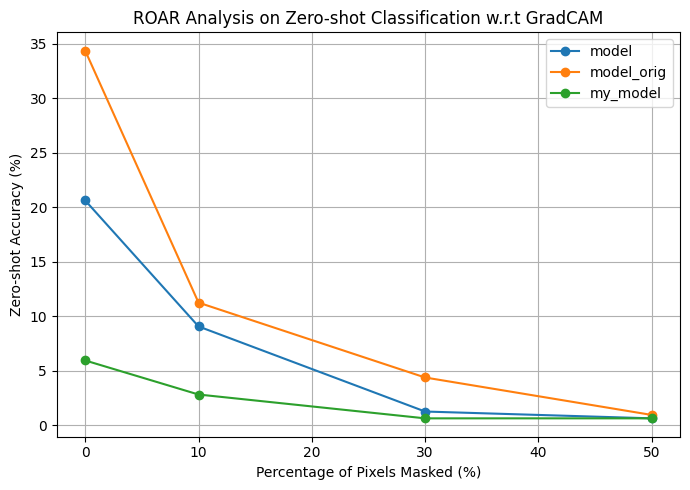

In [36]:
run_roar_analysis(get_importance_map_gradcam, "GradCAM")